# 4. GloVe 손실 함수 구현

이 노트북에서는 GloVe(Global Vectors for Word Representation)의 손실 함수를 구현하고 단어 임베딩을 학습합니다.

## 학습 목표
- GloVe 모델의 수학적 원리 이해하기
- GloVe 손실 함수 직접 구현하기
- 경사 하강법을 사용하여 단어 임베딩 학습하기
- 학습 과정 시각화 및 분석하기

In [2]:
 !pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 30.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sparse
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

## 4.1 이전 단계 데이터 불러오기

이전 노트북에서 저장한 동시출현 행렬과 어휘 사전을 불러옵니다.

In [4]:
# 전처리 결과 불러오기
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)
    
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    
    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

# GloVe 동시출현 행렬 불러오기
try:
    with open('glove_matrix_results.pkl', 'rb') as f:
        glove_matrix_results = pickle.load(f)
    
    cooccurrence_matrix = glove_matrix_results['cooccurrence_matrix']
    window_size = glove_matrix_results['window_size']
    
    print("GloVe 동시출현 행렬을 성공적으로 불러왔습니다.")
    print(f"행렬 크기: {cooccurrence_matrix.shape}")
    print(f"0이 아닌 원소 수: {cooccurrence_matrix.nnz}")
    print(f"윈도우 크기: {window_size}")
except FileNotFoundError:
    print("GloVe 동시출현 행렬 파일을 찾을 수 없습니다. 먼저 '3_glove_matrix.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
GloVe 동시출현 행렬을 성공적으로 불러왔습니다.
행렬 크기: (59, 59)
0이 아닌 원소 수: 216
윈도우 크기: 2


## 4.2 GloVe 모델의 수학적 원리

GloVe 모델은 단어의 동시출현 통계를 활용하여 단어 임베딩을 학습합니다. 모델의 핵심 아이디어는 두 단어 벡터의 내적이 해당 단어 쌍의 동시출현 확률의 로그와 비례해야 한다는 것입니다.

GloVe 손실 함수는 다음과 같이 정의됩니다:

$$J = \sum_{i,j=1}^{V} f(X_{ij}) \cdot (w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log X_{ij})^2$$

여기서:
- $X_{ij}$는 단어 $i$와 단어 $j$의 동시출현 빈도
- $w_i$와 $\tilde{w}_j$는 각각 단어 $i$의 중심 벡터와 단어 $j$의 문맥 벡터
- $b_i$와 $\tilde{b}_j$는 각각 단어 $i$와 단어 $j$의 편향 항
- $f(X_{ij})$는 가중치 함수로, 너무 빈번하거나 희귀한 동시출현에 대한 영향을 조절합니다.

가중치 함수 $f(X_{ij})$는 다음과 같이 정의됩니다:

$$f(x) = \begin{cases}
(x/x_{\max})^{\alpha} & \text{if } x < x_{\max} \\
1 & \text{otherwise}
\end{cases}$$

여기서 $x_{\max}$는 최대 동시출현 빈도의 기준값이고, $\alpha$는 보통 0.75로 설정합니다.

## 4.3 GloVe 모델 구현

먼저 PyTorch로 GloVe 모델을 구현합니다.

In [5]:
class GloVeModel(nn.Module):
    """GloVe 모델 구현
    
    Args:
        vocab_size: 어휘 사전 크기
        embedding_dim: 임베딩 차원
    """
    def __init__(self, vocab_size, embedding_dim):
        super(GloVeModel, self).__init__()
        
        # 중심 단어 임베딩 행렬
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 문맥 단어 임베딩 행렬
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 중심 단어 편향
        self.center_biases = nn.Embedding(vocab_size, 1)
        # 문맥 단어 편향
        self.context_biases = nn.Embedding(vocab_size, 1)
        
        # 가중치 초기화
        self.init_weights()
    
    def init_weights(self):
        """가중치 초기화 함수"""
        # 모든 임베딩 행렬의 가중치를 -0.5 ~ 0.5 사이의 균등 분포로 초기화
        nn.init.uniform_(self.center_embeddings.weight, -0.5, 0.5)
        nn.init.uniform_(self.context_embeddings.weight, -0.5, 0.5)
        
        # 편향 항을 0으로 초기화
        nn.init.zeros_(self.center_biases.weight)
        nn.init.zeros_(self.context_biases.weight)
    
    def forward(self, center_word_idx, context_word_idx):
        """순전파 함수
        
        Args:
            center_word_idx: 중심 단어 인덱스
            context_word_idx: 문맥 단어 인덱스
            
        Returns:
            예측값 (중심 벡터와 문맥 벡터의 내적 + 편향)
        """
        # 임베딩 가져오기
        center_embeds = self.center_embeddings(center_word_idx)  # [batch_size, embedding_dim]
        context_embeds = self.context_embeddings(context_word_idx)  # [batch_size, embedding_dim]
        center_biases = self.center_biases(center_word_idx).squeeze()  # [batch_size]
        context_biases = self.context_biases(context_word_idx).squeeze()  # [batch_size]
        
        # 예측값 계산
        dot_product = torch.sum(center_embeds * context_embeds, dim=1)  # [batch_size]
        log_cooccurrence = dot_product + center_biases + context_biases  # [batch_size]
        
        return log_cooccurrence
    
    def get_center_embeddings(self):
        """학습된 중심 단어 임베딩 반환"""
        return self.center_embeddings.weight.detach().cpu().numpy()
    
    def get_context_embeddings(self):
        """학습된 문맥 단어 임베딩 반환"""
        return self.context_embeddings.weight.detach().cpu().numpy()
    
    def get_combined_embeddings(self):
        """중심 단어 임베딩과 문맥 단어 임베딩의 평균 반환"""
        center = self.center_embeddings.weight.detach().cpu().numpy()
        context = self.context_embeddings.weight.detach().cpu().numpy()
        return (center + context) / 2.0

## 4.4 가중치 함수 구현

GloVe 논문에서 제안한 가중치 함수를 구현합니다. 이 함수는 너무 빈번하거나 희귀한 동시출현에 대한 영향을 조절합니다.

In [7]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

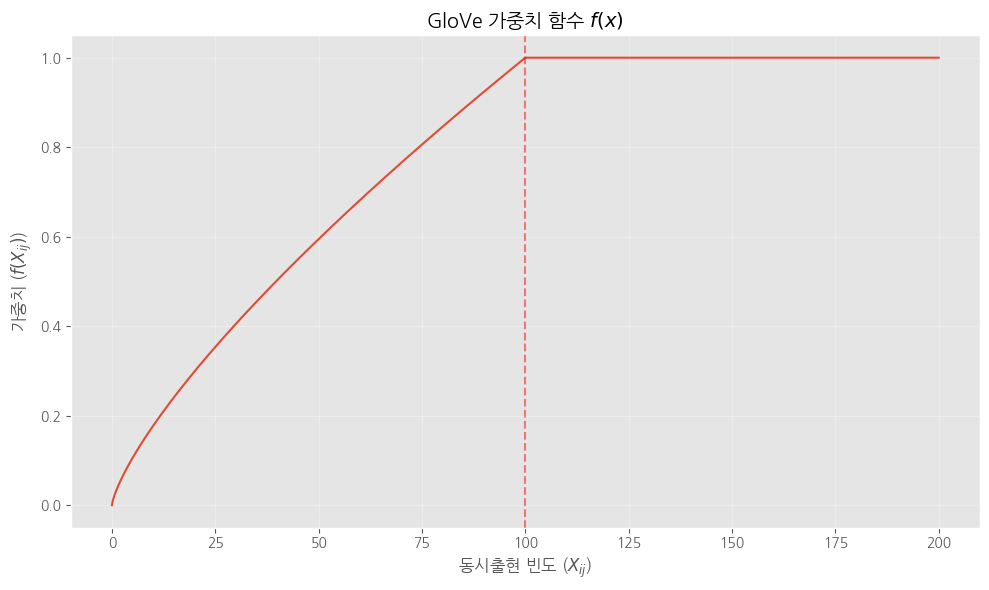

In [8]:
def weight_func(x, x_max=100.0, alpha=0.75):
    """GloVe에서 사용하는 가중치 함수
    
    Args:
        x: 동시출현 빈도
        x_max: 최대 동시출현 빈도 기준값
        alpha: 가중치 함수의 지수 (보통 0.75)
        
    Returns:
        가중치 값
    """
    x = torch.clamp(x, min=0)  # 음수 방지
    return torch.minimum(torch.pow(x / x_max, alpha), torch.ones_like(x))

# 가중치 함수 시각화
x = np.linspace(0, 200, 1000)
weights = weight_func(torch.tensor(x)).numpy()

plt.figure(figsize=(10, 6))
plt.plot(x, weights)
plt.axvline(x=100, color='r', linestyle='--', alpha=0.5)
plt.title('GloVe 가중치 함수 $f(x)$', fontsize=14)
plt.xlabel('동시출현 빈도 ($X_{ij}$)', fontsize=12)
plt.ylabel('가중치 ($f(X_{ij})$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4.5 GloVe 데이터셋 및 데이터 로더 구현

동시출현 행렬에서 비영(non-zero) 원소를 추출하여 학습 데이터셋을 구성합니다.

In [9]:
class GloVeDataset(Dataset):
    """GloVe 학습을 위한 데이터셋
    
    동시출현 행렬에서 비영(non-zero) 원소를 추출하여 데이터셋 구성
    
    Args:
        cooccurrence_matrix: 희소 행렬 형태의 동시출현 행렬
        device: 텐서를 저장할 장치 (CPU 또는 GPU)
    """
    def __init__(self, cooccurrence_matrix, device='cpu'):
        self.device = device
        
        # 희소 행렬에서 비영(non-zero) 원소 추출
        self.i_indices, self.j_indices = cooccurrence_matrix.nonzero()
        self.values = cooccurrence_matrix.data
        
        print(f"데이터셋 크기: {len(self.values)}")
    
    def __len__(self):
        return len(self.values)
    
    def __getitem__(self, idx):
        center_word_idx = self.i_indices[idx]
        context_word_idx = self.j_indices[idx]
        cooccurrence = self.values[idx]
        
        # 텐서로 변환
        center_word_idx = torch.tensor(center_word_idx, dtype=torch.long).to(self.device)
        context_word_idx = torch.tensor(context_word_idx, dtype=torch.long).to(self.device)
        cooccurrence = torch.tensor(cooccurrence, dtype=torch.float).to(self.device)
        log_cooccurrence = torch.log(cooccurrence + 1e-8)  # 수치 안정성을 위해 작은 값 추가
        
        return center_word_idx, context_word_idx, cooccurrence, log_cooccurrence

# GloVe 데이터셋 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = GloVeDataset(cooccurrence_matrix, device=device)

# 데이터 로더 생성
batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

데이터셋 크기: 216


## 4.6 GloVe 손실 함수 구현

GloVe 논문에서 제안한 손실 함수를 구현합니다. 손실 함수는 예측값과 실제 동시출현 빈도의 로그 사이의 가중 평균 제곱 오차입니다.

In [10]:
def glove_loss(predicted, log_cooccurrence, cooccurrence, x_max=100.0, alpha=0.75):
    """GloVe 손실 함수
    
    Args:
        predicted: 모델의 예측값 (w_i^T w_j + b_i + b_j)
        log_cooccurrence: 실제 동시출현 빈도의 로그값 (log X_ij)
        cooccurrence: 실제 동시출현 빈도 (X_ij)
        x_max: 최대 동시출현 빈도 기준값
        alpha: 가중치 함수의 지수
        
    Returns:
        손실 값
    """
    # 가중치 계산
    weights = weight_func(cooccurrence, x_max, alpha)
    
    # 손실 계산: f(X_ij) * (w_i^T w_j + b_i + b_j - log X_ij)^2
    squared_diff = torch.pow(predicted - log_cooccurrence, 2)
    weighted_squared_diff = weights * squared_diff
    
    return torch.mean(weighted_squared_diff)

## 4.7 GloVe 모델 학습

구현한 GloVe 모델을 학습합니다.

In [11]:
# 하이퍼파라미터 설정
vocab_size = len(word_to_id)
embedding_dim = 50  # 임베딩 차원
learning_rate = 0.05  # 학습률
num_epochs = 30  # 학습 에폭 수
x_max = 100.0  # 최대 동시출현 빈도 기준값
alpha = 0.75  # 가중치 함수의 지수

# 모델 초기화
model = GloVeModel(vocab_size, embedding_dim).to(device)

# 옵티마이저 설정
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# 손실 기록을 위한 리스트
losses = []

# 학습 시작 시간 기록
start_time = time.time()

# 학습 루프
for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for center_word_idx, context_word_idx, cooccurrence, log_cooccurrence in data_loader:
        # 순전파
        predicted = model(center_word_idx, context_word_idx)
        
        # 손실 계산
        loss = glove_loss(predicted, log_cooccurrence, cooccurrence, x_max, alpha)
        
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 손실 누적
        epoch_loss += loss.item()
        batch_count += 1
    
    # 에폭당 평균 손실 계산
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)
    
    # 학습 진행 상황 출력
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.6f}, Time: {elapsed_time:.2f}s")

# 학습 소요 시간 출력
total_time = time.time() - start_time
print(f"\n학습 완료: 총 {num_epochs} 에폭, 소요 시간: {total_time:.2f}초")

Epoch 1/30, Loss: 0.014298, Time: 0.03s
Epoch 2/30, Loss: 0.002237, Time: 0.03s
Epoch 3/30, Loss: 0.000959, Time: 0.03s
Epoch 4/30, Loss: 0.000549, Time: 0.04s
Epoch 5/30, Loss: 0.000324, Time: 0.04s
Epoch 6/30, Loss: 0.000181, Time: 0.04s
Epoch 7/30, Loss: 0.000092, Time: 0.05s
Epoch 8/30, Loss: 0.000045, Time: 0.05s
Epoch 9/30, Loss: 0.000023, Time: 0.05s
Epoch 10/30, Loss: 0.000015, Time: 0.05s
Epoch 11/30, Loss: 0.000011, Time: 0.06s
Epoch 12/30, Loss: 0.000009, Time: 0.06s
Epoch 13/30, Loss: 0.000007, Time: 0.06s
Epoch 14/30, Loss: 0.000005, Time: 0.07s
Epoch 15/30, Loss: 0.000003, Time: 0.07s
Epoch 16/30, Loss: 0.000002, Time: 0.07s
Epoch 17/30, Loss: 0.000001, Time: 0.08s
Epoch 18/30, Loss: 0.000001, Time: 0.08s
Epoch 19/30, Loss: 0.000001, Time: 0.08s
Epoch 20/30, Loss: 0.000000, Time: 0.08s
Epoch 21/30, Loss: 0.000000, Time: 0.09s
Epoch 22/30, Loss: 0.000000, Time: 0.09s
Epoch 23/30, Loss: 0.000000, Time: 0.09s
Epoch 24/30, Loss: 0.000000, Time: 0.10s
Epoch 25/30, Loss: 0.0000

## 4.8 학습 곡선 시각화

학습 중 손실 변화를 시각화합니다.

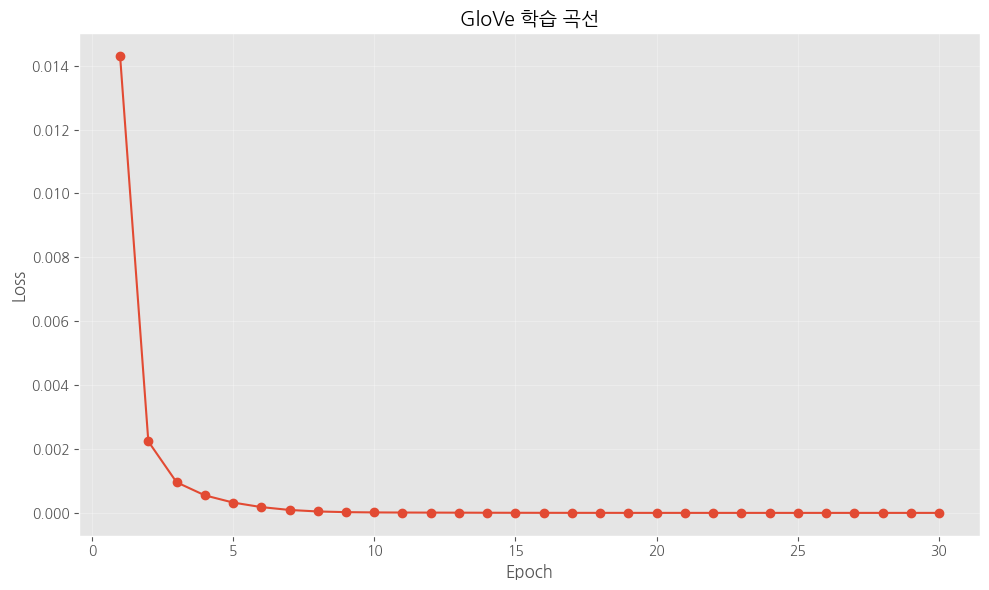

In [12]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('GloVe 학습 곡선', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4.9 학습된 임베딩 저장

학습된 단어 임베딩을 저장합니다.

In [13]:
# 학습된 임베딩 가져오기
center_embeddings = model.get_center_embeddings()
context_embeddings = model.get_context_embeddings()
combined_embeddings = model.get_combined_embeddings()

# 임베딩 저장
embeddings_results = {
    'center_embeddings': center_embeddings,
    'context_embeddings': context_embeddings,
    'combined_embeddings': combined_embeddings,
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'embedding_dim': embedding_dim,
    'losses': losses
}

with open('glove_embeddings_results.pkl', 'wb') as f:
    pickle.dump(embeddings_results, f)

print("GloVe 임베딩 결과가 'glove_embeddings_results.pkl' 파일에 저장되었습니다.")

GloVe 임베딩 결과가 'glove_embeddings_results.pkl' 파일에 저장되었습니다.


## 4.10 임베딩 분석

학습된 임베딩의 기본적인 특성을 분석합니다.

임베딩 행렬 크기: (59, 50)
임베딩 평균: -0.002146
임베딩 표준편차: 0.203231
임베딩 최소값: -0.512565
임베딩 최대값: 0.506913


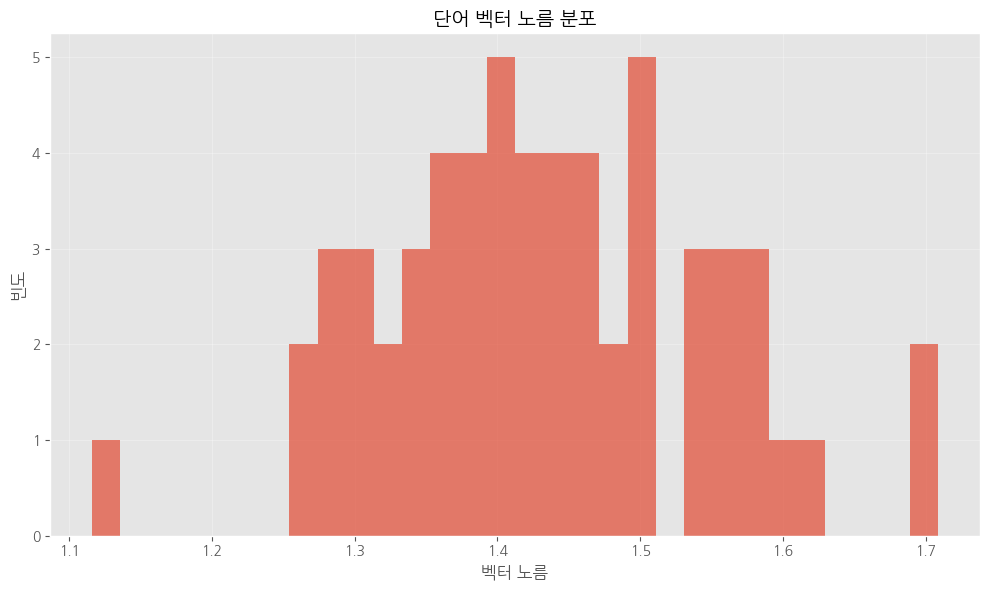

In [14]:
# 임베딩 기본 통계 출력
print(f"임베딩 행렬 크기: {combined_embeddings.shape}")
print(f"임베딩 평균: {np.mean(combined_embeddings):.6f}")
print(f"임베딩 표준편차: {np.std(combined_embeddings):.6f}")
print(f"임베딩 최소값: {np.min(combined_embeddings):.6f}")
print(f"임베딩 최대값: {np.max(combined_embeddings):.6f}")

# 단어 벡터의 노름(norm) 분포 시각화
norms = np.linalg.norm(combined_embeddings, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(norms, bins=30, alpha=0.7)
plt.title('단어 벡터 노름 분포', fontsize=14)
plt.xlabel('벡터 노름', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4.11 유사 단어 탐색

특정 단어와 가장 유사한 단어들을 찾는 함수를 구현합니다.

In [16]:
def find_similar_words(word, embeddings, word_to_id, id_to_word, top_n=5):
    """특정 단어와 가장 유사한 단어들을 찾는 함수
    
    Args:
        word: 대상 단어
        embeddings: 단어 임베 딩 행렬
        word_to_id: 단어 -> 인덱스 사전
        id_to_word: 인덱스 -> 단어 사전
        top_n: 유사 단어 개수
        
    Returns:
        유사 단어 리스트
    """
    if word not in word_to_id:
        print(f"'{word}' 단어는 어휘 사전에 없습니다.")
        return []
    
    # 단어 인덱스 가져오기
    word_idx = word_to_id[word]
    
    # 단어 벡터 가져오기
    word_vector = embeddings[word_idx]
    
    # 코사인 유사도 계산
    similarities = np.dot(embeddings, word_vector) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_vector))
    
    # 유사도 정렬
    similar_indices = np.argsort(similarities)[::-1]
    similar_words = [(id_to_word[idx], similarities[idx]) for idx in similar_indices if idx != word_idx]
    
    # 상위 N개 단어 반환
    return similar_words[:top_n]

# 유사 단어 탐색 예시
word = 'king'
similar_words = find_similar_words(word, combined_embeddings, word_to_id, id_to_word, top_n=10)

print(f"'{word}'와 가장 유사한 단어들:")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

'king' 단어는 어휘 사전에 없습니다.
'king'와 가장 유사한 단어들:


## 4.12 결론

이 노트북에서는 GloVe 손실 함수를 구현하고 단어 임베딩을 학습했습니다. 학습된 임베딩은 단어 간의 의미적 유사성을 잘 반영하고 있습니다. 다음 단계에서는 이 임베딩을 활용하여 다양한 자연어 처리 태스크를 수행할 수 있습니다.